In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

sys.path.insert(0, "../")
from utils import class_sampler, grid_plot, fix_seed
from methods import ProjectionMethod
from models import pretrained

device = 'cuda'
#device = 'cpu'

# Example - MNIST
This example shows how to use our method to create adversarial examples on the MNIST dataset. First, we generate some MNIST data using a pretrained ALI Generator and annotate them using a classifier.
- ```x0``` - Samples generated by the generative model. We apply perturbations to those samples.

## Latent representation
Since we generated the images using a generative model, we can easily obtain their latent representation.

- ```z0``` - latent representation of the original sample.
- ```z_init``` - latent representation of a sample used for initialization.
- ```labels_target``` - labels of z_init. We need it only for a targeted attack.

## Initialization
Selection of sample used for initialization depends on the type of attack:
- Untargeted attacks - Initialize with misclassified examples
- Targeted attacks - Initialize with examples of the target class
In the following example, we choose ```z_init``` as samples from ```z0``` with the index shifted by 1. For example, digit 0 is initialized by digit 1 from ```z0```. This way, targeted attack targets label vector [1, 2, .... 9, 0].

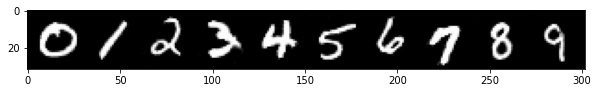

Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [4]:
fix_seed(1)

# Prepare models
generator = pretrained.MnistALI(level='full', device=device)
classifier = pretrained.MnistClassifier(device=device)
classifier_z = lambda z: classifier(generator.decode(z))

# Generate samples
z0 = torch.cat([class_sampler(classifier, generator, c, samples=1, device=device) for c in range(10)])
z_init = torch.roll(z0, 1, dims=0) 
x0 = generator.decode(z0)

# Assign class 
labels = classifier_z(z0).argmax(1)
grid_plot(x0, nrows=10)
print(f"Labels: {labels}")

## Intermediate latent representation
Given latent representations ```z_init``` and  ```z0```, we can obtain their respective intermediate latent representations, ```v_init``` and ```v0```, as vectors collected after activations layer in the decoder network.

- ```v0``` - intermediate latent representation of the original sample.
- ```v_init``` - intermediate latent representation of a sample used for initialization.


In [5]:
# Prepare models and data
layer = 2  # Use features obtained after given layer. Valid values: ['full', 0, 1, 2, 3]
generator = pretrained.MnistALI(layer, device=device)
classifier_v = lambda v: classifier(generator.decode(v))
v0 = generator.encode(z0)

v_init = generator.encode(z_init)
labels_target = classifier_v(v_init).argmax(1)

## 1. l2 attacks

### Untargeted

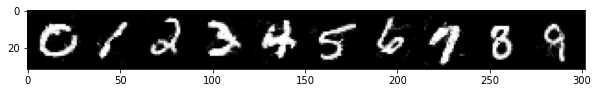

Classified as: tensor([5, 5, 3, 2, 3, 4, 5, 1, 0, 8], device='cuda:0')
Wall time: 53.4 s


In [6]:
%%time
params = {
        'iters': 150, # In paper, we use 1000
        'distance': 'l2',
        'constraint': 'misclassify',
        'xi_c': {'scheduler': 'SchedulerExponential', 'params': {'initial': 1, 'gamma': 0.005}},
        'xi_o': {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
        'threshold': 1
}
attack = ProjectionMethod(**params)
v_per = attack(v0, v_init, classifier_v, generator)
x_per = generator.decode(v_per)

grid_plot(x_per, nrows=10)
print(f"Classified as: {classifier(x_per).argmax(1)}")

### Targeted

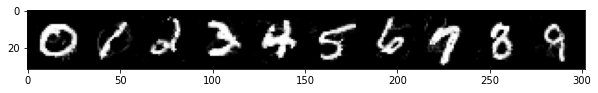

Classified as: tensor([9, 0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
Wall time: 52.8 s


In [7]:
%%time
params = {
        'iters': 150, # In paper, we use 1000
        'distance': 'l2',
        'constraint': 'targeted',
        'xi_c': {'scheduler': 'SchedulerExponential', 'params': {'initial': 1, 'gamma': 0.005}},
        'xi_o': {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
        'threshold': 1,
}      
attack = ProjectionMethod(**params)
v_per = attack(v0, v_init, classifier_v, generator, target=labels_target)
x_per = generator.decode(v_per)

grid_plot(x_per, nrows=10)
print(f"Classified as: {classifier(x_per).argmax(1)}")

## 2. Wasserstein attack

### Untargeted

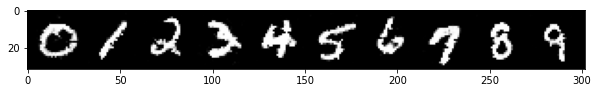

Classified as: tensor([8, 6, 3, 2, 5, 4, 5, 3, 5, 8], device='cuda:0')
Wall time: 57.8 s


In [8]:
%%time
params = {
        'iters': 150, # In paper, we use 1000
        'distance': 'wd',
        'distance_args': {'loss': 'sinkhorn', 'p': 1, 'blur': 0.1, 'scaling': 0.5},
        'constraint': 'misclassify',
        'xi_c': {'scheduler': 'SchedulerExponential', 'params': {'initial': 1, 'gamma': 0.005}},
        'xi_o': {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
        'threshold': 1
}
attack = ProjectionMethod(**params)
v_per = attack(v0, v_init, classifier_v, generator)
x_per = generator.decode(v_per)

grid_plot(x_per, nrows=10)
print(f"Classified as: {classifier(x_per).argmax(1)}")

### Targeted

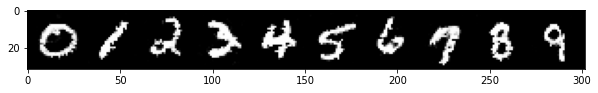

Classified as: tensor([9, 0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
Wall time: 1min 2s


In [9]:
%%time
params = {
        'iters': 150, # In paper, we use 1000
        'distance': 'wd',
        'distance_args': {'loss': 'sinkhorn', 'p': 1, 'blur': 0.1, 'scaling': 0.5},
        'constraint': 'targeted',
        'xi_c': {'scheduler': 'SchedulerExponential', 'params': {'initial': 1, 'gamma': 0.005}},
        'xi_o': {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
        'threshold': 1
}
attack = ProjectionMethod(**params)
v_per = attack(v0, v_init, classifier_v, generator, target=labels_target)
x_per = generator.decode(v_per)

grid_plot(x_per, nrows=10)
print(f"Classified as: {classifier(x_per).argmax(1)}")

# Example Imagenet
In this section, we show how to create images misclassified by the ImageNet classifier. In the untargeted attack, trivial class changes can happen, such as changing the dog’s breed. Therefore, we use targeted version of our algorithm. As the target class, we chose broccoli as it is sufficiently different from animals.


First, we need to load latent representations  ```z0``` from z_animals.npy and ```z_init``` from z_broccoli.npy. Analogically to MNIST example, we construct intermediate latent representations ```v_init```and ```v0```.

We then apply the algorithm on the first animal and initialise it with broccoli, using intermediate latent representation obtained after the third block of the decoder network. Note that the label id of broccoli is 937.

### Data overview

Loaded pretrained weights for efficientnet-b0
Decoded animals
Labels: ['redbone', 'leopard, Panthera pardus', 'oystercatcher, oyster catcher', 'hornbill', 'otterhound, otter hound']


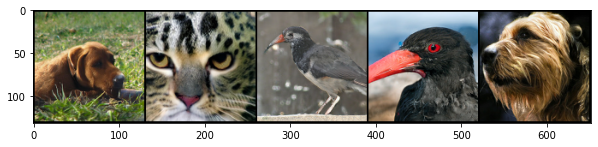

Labels: ['broccoli', 'broccoli', 'broccoli']


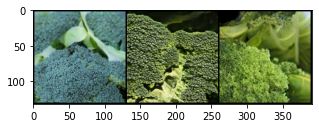

In [10]:
# Load dictionary with Imagenet labels
path = os.path.join('..', 'experiments_imagenet', 'imagenet_labels_map.txt')
import json
with open(path, 'r') as f:
    label_map = json.load(f)

# Load pretrained Imagenet models
classifier = pretrained.EfficientNetClassifier(device)
generator =  pretrained.ImagenetBigBiGAN(None, device)

# Initial images - animals
z_samples = np.load(os.path.join('..', 'experiments_imagenet', 'z_animals.npy'))
z_samples = torch.tensor(z_samples, device=device)
x_samples = generator(z_samples)
print('Decoded animals')
print(f'Labels: {[label_map[str(i.item())] for i in classifier(x_samples).argmax(1)]}')
grid_plot(x_samples, nrows=10)

# Initial images - broccoli
z_init = np.load(os.path.join('..', 'experiments_imagenet', 'z_broccoli.npy'))
z_init = torch.tensor(z_init, device=device)
x_init = generator(z_init)
print(f'Labels: {[label_map[str(i.item())] for i in classifier(x_init).argmax(1)]}')
grid_plot(x_init, nrows=5)

### Attack

In [11]:
# Select animal and initial broccoli
animal = 0
broccoli = 0
target = 937 # id of broccoli class
layer = 3

# Prepare models and data
generator = pretrained.ImagenetBigBiGAN(layer, device=device)
classifier_v = lambda v: classifier(generator.decode(v))

v0 = generator.encode(z_samples[[animal]].to(device))
v_init = generator.encode(z_init[[broccoli]].to(device))
target_labels = torch.tensor([target], dtype=torch.int64, device=device)

In [12]:
params = {
    "iters": 150, # In paper, we use 1000
    "distance": "l2",
    "constraint": "targeted",
    "xi_c": {"scheduler": "SchedulerExponential",
    "params": {"initial": 1, "gamma": 0.005}},
    "xi_o": {"scheduler": "SchedulerConstant", "params": {"alpha": 1}},
    "threshold": 1.0
}

attack = ProjectionMethod(**params)
v_per = attack(v0, v_init, classifier_v, generator, target=target_labels)
x_per = generator.decode(v_per)

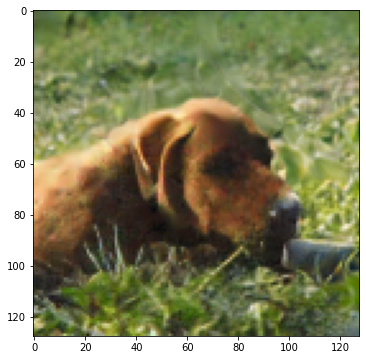

tensor([937], device='cuda:0')


In [15]:
grid_plot(x_per)
print(classifier(x_per).argmax(1))